In [1]:
!nvidia-smi

Fri Jun 14 23:36:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0    58W / 400W |   2195MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from glob import glob
from tqdm import tqdm

In [4]:
root = 'signaldataset/'
all_df_train = glob(root + 'train/train/*.csv')
all_df_test = glob(root + 'test/test_segment/*/*.csv')
len(all_df_train),  len(all_df_test)

(83, 7970)

## Sample

In [5]:
sample_df_train = pd.read_csv(all_df_train[0])
sample_df_train

,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage
0,-23.52,-30.0,-31.0,49.0,31.15,0.585693,70.67,0.796875,W
1,-26.46,-30.0,-31.0,49.0,31.15,0.585693,70.67,0.796875,W
2,-29.41,-30.0,-32.0,49.0,31.15,0.585693,70.67,0.796875,W
3,-32.24,-30.0,-32.0,49.0,31.15,0.585693,70.67,0.796875,W
4,-34.78,-31.0,-32.0,48.0,31.15,0.585693,70.67,0.796875,W
...,...,...,...,...,...,...,...,...,...
1549435,-29.51,14.0,41.0,46.0,34.84,0.571534,49.45,1.187500,W
1549436,-12.62,14.0,42.0,46.0,34.84,0.571534,49.45,1.187500,W
1549437,3.43,14.0,42.0,46.0,34.84,0.571534,49.45,1.187500,W
1549438,18.57,14.0,41.0,46.0,34.84,0.571534,49.45,1.187500,W


In [10]:
labels = sample_df_train['Sleep_Stage'].unique()
ids = range(len(labels))
label2id = dict(zip(labels, ids))
id2label = dict(zip(ids, labels))
label2id, id2label

({'W': 0, 'N': 1, 'R': 2}, {0: 'W', 1: 'N', 2: 'R'})

In [12]:
for key, value in label2id.items():
  sample_df_train.loc[sample_df_train['Sleep_Stage']==key, 'Sleep_Stage'] = value
sample_df_train

,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage
0,-23.52,-30.0,-31.0,49.0,31.15,0.585693,70.67,0.796875,0
1,-26.46,-30.0,-31.0,49.0,31.15,0.585693,70.67,0.796875,0
2,-29.41,-30.0,-32.0,49.0,31.15,0.585693,70.67,0.796875,0
3,-32.24,-30.0,-32.0,49.0,31.15,0.585693,70.67,0.796875,0
4,-34.78,-31.0,-32.0,48.0,31.15,0.585693,70.67,0.796875,0
...,...,...,...,...,...,...,...,...,...
1549435,-29.51,14.0,41.0,46.0,34.84,0.571534,49.45,1.187500,0
1549436,-12.62,14.0,42.0,46.0,34.84,0.571534,49.45,1.187500,0
1549437,3.43,14.0,42.0,46.0,34.84,0.571534,49.45,1.187500,0
1549438,18.57,14.0,41.0,46.0,34.84,0.571534,49.45,1.187500,0


In [13]:
sample_df_train.corr()

,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage
BVP,1.000000,-0.000032,-0.000257,0.000822,0.000027,0.000010,0.000160,-0.000738,-0.000251
ACC_X,-0.000032,1.000000,0.789006,0.516862,-0.109545,0.034103,0.007192,-0.011511,0.258546
ACC_Y,-0.000257,0.789006,1.000000,0.123419,0.197503,0.238495,-0.113977,0.107051,0.305095
ACC_Z,0.000822,0.516862,0.123419,1.000000,-0.282636,-0.336458,0.033909,-0.033403,0.166942
TEMP,0.000027,-0.109545,0.197503,-0.282636,1.000000,0.173110,-0.391673,0.300784,0.268914
EDA,0.000010,0.034103,0.238495,-0.336458,0.173110,1.000000,0.117720,-0.046930,-0.114082
HR,0.000160,0.007192,-0.113977,0.033909,-0.391673,0.117720,1.000000,-0.478762,-0.475636
IBI,-0.000738,-0.011511,0.107051,-0.033403,0.300784,-0.046930,-0.478762,1.000000,0.329698
Sleep_Stage,-0.000251,0.258546,0.305095,0.166942,0.268914,-0.114082,-0.475636,0.329698,1.000000


In [14]:
dropped_columns = 'BVP EDA HR'.split()
dropped_columns

['BVP', 'EDA', 'HR']

## Main Pipeline

use the "dropped_column" and "label2id" and "id2label" from Sample

Read file

In [ ]:
df_trains = []
for path in tqdm(all_df_train):
  df_trains.append(pd.read_csv(path).drop(dropped_columns, axis=1))

In [49]:
df_tests = []
for path in tqdm(all_df_test):
  df_tests.append(pd.read_csv(path).drop(dropped_columns, axis=1))

100%|██████████| 7970/7970 [02:49<00:00, 47.09it/s]


In [52]:
df_tests[0], len(df_tests)

(      ACC_X  ACC_Y  ACC_Z   TEMP      IBI
 0     -64.0    5.0  -10.0  34.25  1.09375
 1     -64.0    5.0  -10.0  34.25  1.09375
 2     -64.0    5.0  -10.0  34.25  1.09375
 3     -64.0    5.0  -10.0  34.25  1.09375
 4     -64.0    5.0  -10.0  34.25  1.09375
 ...     ...    ...    ...    ...      ...
 1915  -64.0    5.0  -10.0  34.23  1.09375
 1916  -64.0    5.0  -10.0  34.23  1.09375
 1917  -64.0    5.0  -10.0  34.23  1.09375
 1918  -64.0    5.0  -10.0  34.23  1.09375
 1919  -64.0    5.0  -10.0  34.23  1.09375
 
 [1920 rows x 5 columns],
 7970)

change label to id

In [20]:
for key, value in tqdm(label2id.items()):
  for df in df_trains:
    df.loc[df['Sleep_Stage']==key, 'Sleep_Stage'] = value
df_trains[0]

,ACC_X,ACC_Y,ACC_Z,TEMP,IBI,Sleep_Stage
0,-30.0,-31.0,49.0,31.15,0.796875,0
1,-30.0,-31.0,49.0,31.15,0.796875,0
2,-30.0,-32.0,49.0,31.15,0.796875,0
3,-30.0,-32.0,49.0,31.15,0.796875,0
4,-31.0,-32.0,48.0,31.15,0.796875,0
...,...,...,...,...,...,...
1549435,14.0,41.0,46.0,34.84,1.187500,0
1549436,14.0,42.0,46.0,34.84,1.187500,0
1549437,14.0,42.0,46.0,34.84,1.187500,0
1549438,14.0,41.0,46.0,34.84,1.187500,0


change to np.array

In [23]:
trains_array = []
for df in tqdm(df_trains):
  trains_array.append(df.values)
trains_array = np.concatenate(trains_array, axis=0)
trains_array.shape

100%|██████████| 83/83 [00:15<00:00,  5.30it/s]


(127885440, 6)

In [53]:
tests_array = []
for df in tqdm(df_tests):
  tests_array.append(df.values)
tests_array = np.array(tests_array)
tests_array.shape

100%|██████████| 7970/7970 [00:00<00:00, 510890.74it/s]


(7970, 1920, 5)

segment

In [40]:
from scipy.stats import mode

window_size = 30 * 64 # 30 s, 64 Hz
stride = window_size # no overlap
train_segment = []
y = []
t = trains_array.shape[0]
for i in tqdm(range(0, t-window_size, stride)):
  # exclude the label
  train_segment.append(trains_array[i:i+window_size, :-1])
  y.append(mode(trains_array[i:i+window_size, -1].astype(int))[0])

train_segment = np.array(train_segment)
y = np.array(y)

train_segment.shape, y.shape

100%|██████████| 66606/66606 [00:15<00:00, 4170.98it/s]


((66606, 1920, 5), (66606,))

flatten

In [41]:
p, t, f = train_segment.shape
flatten_trains = train_segment.reshape(p, t*f)
flatten_trains.shape

(66606, 9600)

In [54]:
p, t, f = tests_array.shape
flatten_tests = tests_array.reshape(p, t*f)
flatten_tests.shape

(7970, 9600)

## Model

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

In [43]:
X_train, X_test, y_train, y_test = train_test_split(flatten_trains, y, test_size=0.2)
X_train.shape, y_train.shape

((53284, 9600), (53284,))

## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train_ = flatten_trains.copy()
X_test_ = X_test.copy()
y_train_ = y.copy()
y_test_ = y_test.copy()

clf = RandomForestClassifier(max_depth=None, random_state=888, n_estimators=2000)
clf.fit(X_train_, y_train_)


In [ ]:
import pickle

f = open('sleepRFful.pkl', 'wb')
pickle.dump(clf, f)
f.close()

f1_score:  0.8700807462686311


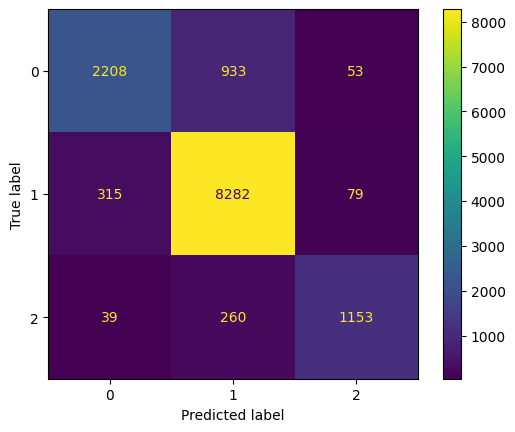

In [46]:

y_pred = clf.predict(X_test_)
# print('accuracy_score: ', accuracy_score(y_test_, y_pred))
print('f1_score: ', f1_score(y_test_, y_pred, average='weighted'))
cm = confusion_matrix(y_test_, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

# Submit

In [55]:
predict = clf.predict(flatten_tests)
predict

array([1, 0, 1, ..., 1, 1, 1])

In [58]:
predict = predict.astype(object)
for key, value in id2label.items():
  predict[predict==key] = value
predict

array(['N', 'W', 'N', ..., 'N', 'N', 'N'], dtype=object)

In [59]:
submit = pd.read_csv(root + 'sample_submission.csv')
submit

,id,labels
0,test001_00000,W
1,test001_00001,W
2,test001_00002,W
3,test001_00003,NaN
4,test001_00004,NaN
...,...,...
7965,test010_00857,NaN
7966,test010_00858,NaN
7967,test010_00859,NaN
7968,test010_00860,NaN


In [60]:
submit['labels'] = predict
submit

,id,labels
0,test001_00000,N
1,test001_00001,W
2,test001_00002,N
3,test001_00003,N
4,test001_00004,N
...,...,...
7965,test010_00857,N
7966,test010_00858,W
7967,test010_00859,N
7968,test010_00860,N


In [61]:
submit['labels'].iloc[0:3] = ['W']*3
submit

,id,labels
0,test001_00000,W
1,test001_00001,W
2,test001_00002,W
3,test001_00003,N
4,test001_00004,N
...,...,...
7965,test010_00857,N
7966,test010_00858,W
7967,test010_00859,N
7968,test010_00860,N


In [63]:
submit.to_csv('sleep_submit.csv', index=False)